In [1]:
import torch
import open_clip
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import random_split
import torch.nn as nn
from PIL import Image

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = ImageFolder(root="Final_dataset_small/Train", transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = ImageFolder(root="Final_dataset_small/Validation", transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Sub dataset 10% of the original dataset
full_dataset_size = len(train_dataset)
sub_dataset_size = int(0.1 * full_dataset_size)
remaining_size = full_dataset_size - sub_dataset_size
sub_dataset, _ = random_split(train_dataset, [sub_dataset_size, remaining_size])
sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=32, shuffle=True)

c:\Users\Juanma\anaconda3\envs\new-tfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
model = model.to(device)

In [3]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataset:
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

results = []

test_features, test_labels = get_features(test_dataloader)
print(test_features.shape)

for percentile in [0.20, 0.40, 0.60, 0.80]:
    for i in range(10):
        print(f"Percentile = {percentile}, iteration = {i}")
        # Sub dataset 10% of the original dataset
        full_dataset_size = len(train_dataset)
        sub_dataset_size = int(percentile * full_dataset_size)
        remaining_size = full_dataset_size - sub_dataset_size
        sub_dataset, _ = random_split(train_dataset, [sub_dataset_size, remaining_size])
        sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=32, shuffle=True)

        # Calculate the image features
        train_features, train_labels = get_features(sub_dataloader)
        print(train_features.shape)
        
        # Perform logistic regression
        classifier = LogisticRegression(random_state=0, C=0.316, max_iter=2000, verbose=1, n_jobs=-1)
        print("Training...")
        classifier.fit(train_features, train_labels)
        print("Done!")

        # Evaluate using the logistic regression classifier
        predictions = classifier.predict(test_features)
        accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
        print(f"Accuracy = {accuracy:.3f}")

        results.append((percentile, i, accuracy))

# Save the results
np.save("results2.npy", results)

In [6]:
# Save classifier sklearn
import pickle
pickle.dump(classifier, open("classifier.pkl", "wb"))

# Load classifier sklearn
import pickle
classifier = pickle.load(open("classifier.pkl", "rb"))

In [4]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle
classifier = pickle.load(open("classifier.pkl", "rb"))

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataset:
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

results = []

test_features, test_labels = get_features(test_dataloader)

predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

# Show accuracy for each class
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

Accuracy = 92.745
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       500
           1       0.93      0.91      0.92       500
           2       0.95      0.97      0.96       500
           3       0.94      0.90      0.92       400
           4       0.98      0.99      0.99       300
           5       0.93      0.89      0.91       500
           6       0.93      0.95      0.94       500
           7       0.90      0.88      0.89       500
           8       0.97      0.99      0.98       500
           9       0.93      0.90      0.92       500

    accuracy                           0.93      4700
   macro avg       0.93      0.93      0.93      4700
weighted avg       0.93      0.93      0.93      4700



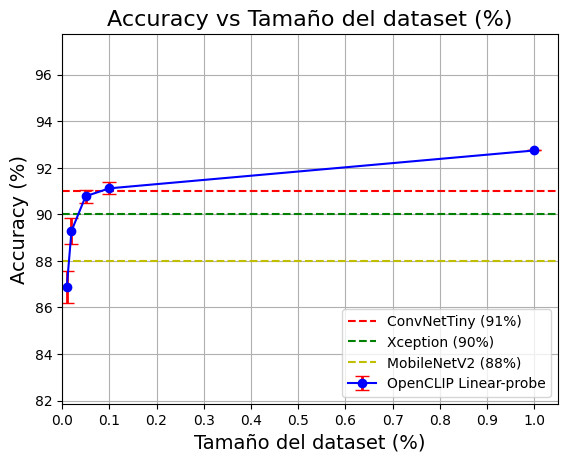

In [5]:
import matplotlib.pyplot as plt
import numpy as np

results = np.load("results.npy", allow_pickle=True)

percentiles = [0.01, 0.02, 0.05, 0.10]
accuracies = []
for percentile in percentiles:
    accuracies.append([result[2] for result in results if result[0] == percentile])

percentiles.append(1.0)

accuracies = np.array(accuracies)
accuracies_mean = np.mean(accuracies, axis=1)
accuracies_mean = np.concatenate((accuracies_mean, [92.745]))
accuracies_std = np.std(accuracies, axis=1)
accuracies_std = np.concatenate((accuracies_std, [0]))

# Crear la figura y el eje
fig, ax = plt.subplots()

# Generar gráfico de barras de error
ax.errorbar(percentiles, accuracies_mean, yerr=accuracies_std, fmt='o-', color='b', ecolor='r', elinewidth=2, capsize=5)

# Añadir líneas para los accuracies de los modelos ConvNetTiny, Xception, y MobileNetV2
ax.axhline(y=0.91*100, color='r', linestyle='--')
ax.axhline(y=0.90*100, color='g', linestyle='--')
ax.axhline(y=0.88*100, color='y', linestyle='--')

# Establecer título, etiquetas de eje x y eje y
ax.set_xlabel("Tamaño del dataset (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("Accuracy vs Tamaño del dataset (%)", fontsize=16)

# Mostrar xticks cada 0.1
ax.set_xticks(np.arange(0, 1.1, 0.1))

# Añadir leyenda
ax.legend(['ConvNetTiny (91%)', 'Xception (90%)', 'MobileNetV2 (88%)', 'OpenCLIP Linear-probe'], loc='lower right')

# Ajustar los límites de los ejes
ax.set_xlim([0, 1.05])
ax.set_ylim([np.min(accuracies_mean)-5, np.max(accuracies_mean)+5])

# Mostrar la grilla
ax.grid(True)

# Guardar el gráfico en un archivo de alta resolución
plt.savefig("accuracy_vs_percentile.png", dpi=300)

# Mostrar el gráfico
plt.show()
